sklearnのみを使用した単純なモデルでトップ25％に到達する方法¶
セルゲイ・ネビアドムスキ
ライブラリとデータのインポート
それが私の簡単なアンサンブルモデルであり、上位40％に到達するのに役立ちました。 分析とモデルの作成中に行ったすべての手順を簡単に説明します。

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble,tree,linear_model
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.utils import shuffle

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [2]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


NAの確認

In [3]:
#欠落データの確認
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]


,Train,Test
Alley,1369,1352.0
BsmtCond,37,45.0
BsmtExposure,38,44.0
BsmtFinSF1,0,1.0
BsmtFinSF2,0,1.0
BsmtFinType1,37,42.0
BsmtFinType2,38,42.0
BsmtFullBath,0,2.0
BsmtHalfBath,0,2.0
BsmtQual,37,44.0


関数をインポートする

In [4]:
#R2およびRMSEスコアを印刷します
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

#トレインおよび検証セットのスコアを表示します 
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)

    print(estimator)
  
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
  
    print("Test")
    get_score(prediction_test, y_tst)

機能とラベルに分割し、不要な変数を削除する

In [5]:
#機能とラベルに分割し、不要な変数を削除する
train_labels = train.pop('SalePrice')

features = pd.concat([train, test], keys=['train', 'test'])

#情報の半分以上が含まれているか、SalePriceと相関しない機能を削除することにしました
features.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'],
              axis=1, inplace=True)

NAの入力と機能の変換

In [6]:
#strとしてのMSSubClass
features['MSSubClass'] = features['MSSubClass'].astype(str)

#prezのMSZoning NA。 最も人気のある値で埋める
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])

#全部でLotFrontage NA。 NAは0を意味すると思います
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

#すべての路地NA。 NAはアクセスなしを意味します
features['Alley'] = features['Alley'].fillna('NOACCESS')

#OverallCondをstrに変換する
features.OverallCond = features.OverallCond.astype(str)

#MasVnrType NAすべてで。 最も人気のある値で埋める
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])


#すべてではない。 NAは地下室がないことを意味します
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NoBSMT')
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

#predの電気NA 最も人気のある値で埋める
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

#カテゴリーへのKitchenAbvGr
features['KitchenAbvGr'] = features['KitchenAbvGr'].astype(str)

#predのKitchenQual NA 最も人気のある値で埋める
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

#全部でFireplaceQu NA。 NAは暖炉なしを意味します
features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

#GarageType、GarageFinish、GarageQual NAのすべて。 NAはガレージなしを意味します
for col in ('GarageType', 'GarageFinish', 'GarageQual'):
    features[col] = features[col].fillna('NoGRG')

#PredのGarageCars NA NAは0を意味すると思います    
features['GarageCars'] = features['GarageCars'].fillna(0.0)

#predのSaleType NA 最も人気のある値で埋める
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

#カテゴリーへの年と月
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

#合計平方フィートフィーチャーの追加と、地下1階および2階のフィーチャーの削除
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

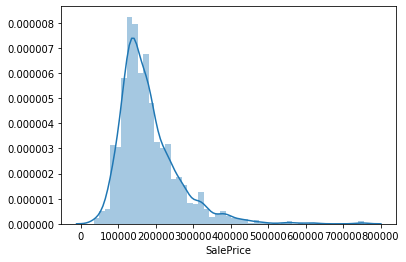

In [7]:
#ログ変換

#SalesPriceは右に傾いています（下のプロットを確認してください）。 私はそれをログ変換しています。
ax=sns.distplot(train_labels)

In [8]:
#ラベルのログ変換
train_labels=np.log(train_labels)

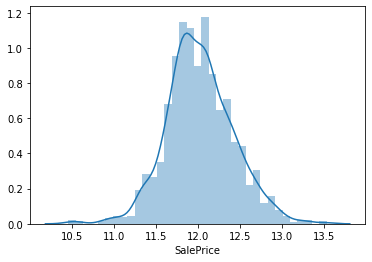

In [9]:
#今ではずっと良く見えます
ax=sns.distplot(train_labels)

数値データの標準化

In [10]:
#数値機能の標準化
numeric_features=features.loc[:,["LotFrontage","LotArea","GrLivArea","TotalSF"]]
numeric_features_standardized=(numeric_features - numeric_features.mean())/numeric_features.std()

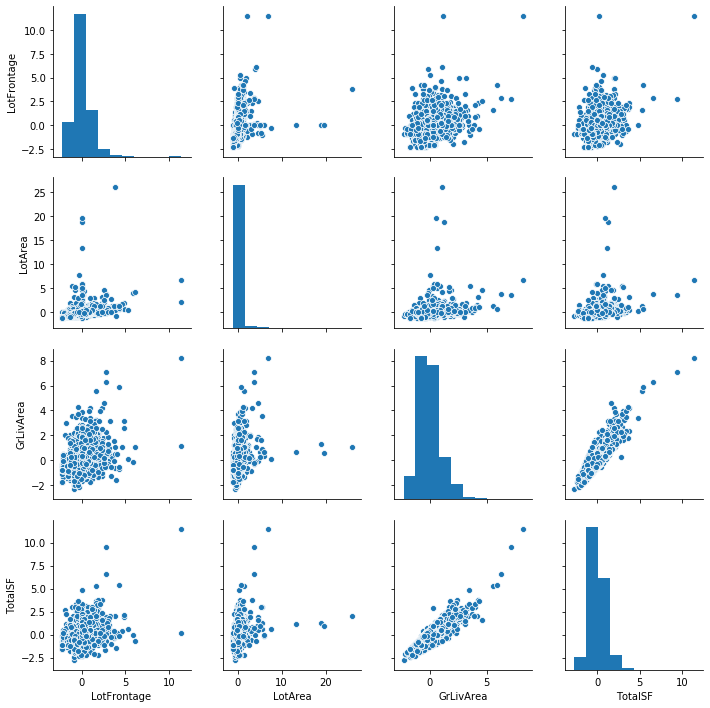

In [11]:
ax=sns.pairplot(numeric_features_standardized)

カテゴリデータをダミーに変換する

In [12]:
#Condition1およびCondition2からダミーを取得する
conditions = set([x for x in features['Condition1']] + [x for x in features['Condition2']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(conditions))),
                       index=features.index, columns=conditions)
for i, cond in enumerate(zip(features['Condition1'], features['Condition2'])):
    dummies.ix[i, cond] = 1
features = pd.concat([features, dummies.add_prefix('Condition_')], axis=1)
features.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

#外装1番目と外装2番目からダミーを取得する
exteriors = set([x for x in features['Exterior1st']] + [x for x in features['Exterior2nd']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(exteriors))),
                       index=features.index, columns=exteriors)
for i, ext in enumerate(zip(features['Exterior1st'], features['Exterior2nd'])):
    dummies.ix[i, ext] = 1
features = pd.concat([features, dummies.add_prefix('Exterior_')], axis=1)
features.drop(['Exterior1st', 'Exterior2nd', 'Exterior_nan'], axis=1, inplace=True)


for col in features.dtypes[features.dtypes == 'object'].index:
    for_dummy = features.pop(col)
    features = pd.concat([features, pd.get_dummies(for_dummy, prefix=col)], axis=1)


他のすべてのカテゴリ変数からダミーを取得する

In [13]:
#機能のコピー
features_standardized = features.copy()

#標準化された値による数値フィーチャの置き換え
features_standardized.update(numeric_features_standardized)

トレインとテスト機能の分割

In [14]:
#分割機能
train_features = features.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features = features.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

#標準化された機能の分割
train_features_st = features_standardized.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features_st = features_standardized.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

トレーニングセットと検証セットへの分割

In [15]:
#列車セットのシャッフル
train_features_st, train_features, train_labels = shuffle(train_features_st, train_features, train_labels, random_state = 5)

In [16]:
#分割
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.1, random_state=200)
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=200)

最初のレベルのモデル
私の分析では、勾配ブースティングとElastic Net（標準化された機能を使用）が最良の結果を示すことが明らかになりました。

エラスティックネット
ElasticNetモデルに最適なアルファとl1_ratioを選択するためにElasticNetCV推定器を使用しています。

In [17]:
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(x_train_st, y_train_st)
train_test(ENSTest, x_train_st, x_test_st, y_train_st, y_test_st)

ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
             cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], max_iter=5000, n_alphas=100,
             n_jobs=None, normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)
R2: 0.9009283220212386
RMSE: 0.11921418684289047
Test
R2: 0.8967299280586054
RMSE: 0.11097043854044887


In [18]:
#平均R2スコアと5倍交差検定の標準偏差
scores=cross_val_score(ENSTest,train_features_st,train_labels,cv=5)
print("Accuracy: %0.2f(+/- %0.2f)" % (scores.mean(),scores.std()*2))

Accuracy: 0.88(+/- 0.10)


勾配ブースティング
多くの機能を使用し、多くの外れ値があります。 そのため、max_features = 'sqrt'を使用して、モデルの過剰適合を減らしています。 また、外れ値に対してより耐性があるため、loss = 'huber'を使用します。 他のすべてのハイパーパラメーターは、GridSearchCVを使用して選択されました。

In [22]:
GBest=ensemble.GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,max_depth=3,max_features="sqrt",
                                        min_samples_leaf=15,min_samples_split=10,loss="huber").fit(x_train,y_train)
train_test(GBest,x_train,x_test,y_train,y_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='huber', max_depth=3,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
R2: 0.9615442556460602
RMSE: 0.07620866033980533
Test
R2: 0.9063105331746739
RMSE: 0.10568771560890751


In [24]:
scores=cross_val_score(GBest,train_features_st,train_labels,cv=5)
print("Accuracy: %0.2f(+/- %0.2f)" % (scores.mean(),scores.std()*2))

Accuracy: 0.89(+/- 0.04)


最終モデルの組み立て
私の最終的なアンサンブルモデルは、勾配ブースティングとElastic Net予測の平均です。 しかしその前に、すべての列車データでモデルを再訓練しました。

In [25]:
#モデルの再トレーニング
GB_model=GBest.fit(train_features,train_labels)
ENST_model=ENSTest.fit(train_features_st,train_labels)

In [27]:
#SalePrice見積もりの取得
Final_labels=(np.exp(GB_model.predict(test_features))+np.exp(ENST_model.predict(test_features_st)))/2

In [ ]:
#CSVに保存
pd.DataFrame({'Id': test.Id, 'SalePrice': Final_labels}).to_c\\\\\\\\\\sv('2017-02-28.csv', index =False)  